# Implementing TF-IDF
------------------------------------

Here we implement TF-IDF, (Text Frequency - Inverse Document Frequency) for the spam-ham text data.

We will use a hybrid approach of encoding the texts with sci-kit learn's TFIDF vectorizer.  Then we will use the regular TensorFlow logistic algorithm outline.

Creating the TF-IDF vectors requires us to load all the text into memory and count the occurrences of each word before we can start training our model.  Because of this, it is not implemented fully in Tensorflow, so we will use Scikit-learn for creating our TF-IDF embedding, but use Tensorflow to fit the logistic model.

We start by loading the necessary libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops
ops.reset_default_graph()

Start a computational graph session.

In [2]:
sess = tf.Session()

We set two parameters, `batch_size` and `max_features`.  `batch_size` is the size of the batch we will train our logistic model on, and `max_features` is the maximum number of tf-idf textual words we will use in our logistic regression.

In [3]:
batch_size = 200
max_features = 1000

Check if data was downloaded, otherwise download it and save for future use

In [4]:
save_file_name = 'temp_spam_data.csv'
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

We now clean our texts. This will decrease our vocabulary size by converting everything to lower case, removing punctuation and getting rid of numbers.

In [5]:
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

# Relabel 'spam' as 1, 'ham' as 0
target = [1. if x=='spam' else 0. for x in target]

# Normalize text
# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

In [16]:
texts[:5]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though']

Define tokenizer function and create the TF-IDF vectors with SciKit-Learn.

In [6]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# Create TF-IDF of texts
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

Split up data set into train/test.

In [9]:
sparse_tfidf_texts.shape[0]

5574

In [10]:
train_indices = np.random.choice(sparse_tfidf_texts.shape[0], int(0.8*sparse_tfidf_texts.shape[0]), replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [17]:
target_train[:5]

array([ 0.,  1.,  0.,  1.,  0.])

In [18]:
texts_train[:5]

<5x1000 sparse matrix of type '<type 'numpy.float64'>'
	with 27 stored elements in Compressed Sparse Row format>

Now we create the variables and placeholders necessary for logistic regression.  After which, we declare our logistic regression operation.  Remember that the sigmoid part of the logistic regression will be in the loss function.

In [11]:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[max_features,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(x_data, A), b)

Next, we declare the loss function (which has the sigmoid in it), and the prediction function.  The prediction function will have to have a sigmoid inside of it because it is not in the model output.

In [12]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

Now we create the optimization function and initialize the model variables.

In [13]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

Finally, we perform our logisitic regression on the 1000 TF-IDF features.

In [14]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 0.78 (0.78). Train Acc (Test Acc): 0.51 (0.51)
Generation # 1000. Train Loss (Test Loss): 0.63 (0.66). Train Acc (Test Acc): 0.65 (0.64)
Generation # 1500. Train Loss (Test Loss): 0.58 (0.59). Train Acc (Test Acc): 0.74 (0.72)
Generation # 2000. Train Loss (Test Loss): 0.54 (0.54). Train Acc (Test Acc): 0.74 (0.78)
Generation # 2500. Train Loss (Test Loss): 0.54 (0.52). Train Acc (Test Acc): 0.76 (0.80)
Generation # 3000. Train Loss (Test Loss): 0.50 (0.50). Train Acc (Test Acc): 0.81 (0.81)
Generation # 3500. Train Loss (Test Loss): 0.46 (0.49). Train Acc (Test Acc): 0.84 (0.82)
Generation # 4000. Train Loss (Test Loss): 0.41 (0.48). Train Acc (Test Acc): 0.86 (0.82)
Generation # 4500. Train Loss (Test Loss): 0.48 (0.48). Train Acc (Test Acc): 0.83 (0.83)
Generation # 5000. Train Loss (Test Loss): 0.42 (0.48). Train Acc (Test Acc): 0.85 (0.83)
Generation # 5500. Train Loss (Test Loss): 0.43 (0.47). Train Acc (Test Acc): 0.84 (0.83)
Generation 

Here is matplotlib code to plot the loss and accuracies.

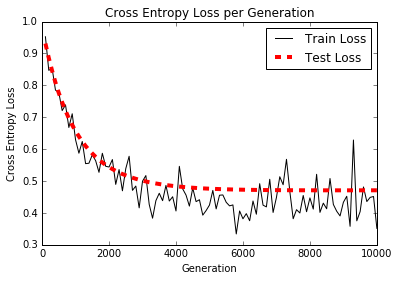

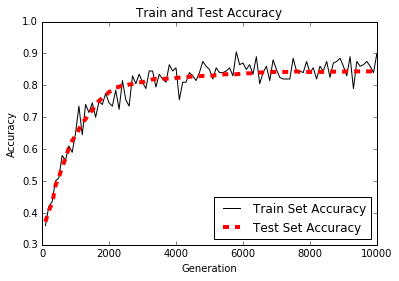

In [15]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()